In [ ]:
!conda install -c conda-forge zfit hist mplhep awkward1 uproot4 iminuit pyhf -y

In [ ]:
!conda install hepunits -c conda-forge -y

In [ ]:
!pip install neos hepstats

In [ ]:
!conda install zfit tensorflow=2.2 tensorflow-probability=0.7 -c conda-forge -y

In [ ]:
!conda update -c conda-forge root -y

# HEP analysis in Python

Previously in this course you've learnt about different ML techniques and how can they be used in HEP analysis. Now the question is how can we integrate all this ML stuff into typical analysis workflow. Today we will disscuss one possible answer - doing the entire analysis with python using __[scikit-hep](https://scikit-hep.org/)__

NB: This seminar's aim is to only provide some introduction into the scikit-hep ecosystem and it by no means provides a complete picture, for more information on topics discussed below you can follow links that will be provided along the way.

This seminar is in large part based on the materials from this __[workshop](https://indico.cern.ch/event/882824/timetable/#20200713.detailed)__

## 1. I/O with .root files

### PyROOT - dynamic bindings to ROOT

One way to work with root files in python many of may be already familiar with is to use PyROOT - dynamic python bindings to ROOT framework and C++. 

In [1]:
import ROOT
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/06


ROOT 6.22, a major revision of PyROOT has been released. The new PyROOT has extensive support for modern C++ (it operates on top of __[cppyy](https://cppyy.readthedocs.io)__)

Here is an example of how you can access C++ objects from python using this functionality

In [2]:
v1 = ROOT.std.vector['float']((1, 2, 3))
print("ROOT.std.vector['float']", v1)

v2 = np.asarray(v1)
print('numpy.array', v2)

v1[0] = 42
print('numpy.array', v2)

ROOT.std.vector['float'] { 1.00000f, 2.00000f, 3.00000f }
numpy.array [1. 2. 3.]
numpy.array [42.  2.  3.]


In [3]:
v1 = np.array((1, 2, 3), dtype=np.float32)
print('numpy.array', v1)

v2 = ROOT.VecOps.AsRVec(v1)
print("ROOT.RVec['float']", v2)

v1[0] = 42
print("ROOT.RVec['float']", v2)

numpy.array [1. 2. 3.]
ROOT.RVec['float'] { 1.00000f, 2.00000f, 3.00000f }
ROOT.RVec['float'] { 42.0000f, 2.00000f, 3.00000f }


We can call usuall  C++ commands under Pyhton enviroment:

In [4]:
ROOT.gInterpreter.Declare('''
float get_element(float* v, unsigned int i) {
    return v[i];
}
''')

print('The first element of the numpy.array is', ROOT.get_element(v1, 0))

The first element of the numpy.array is 42.0


With PyROOT you can use usual ROOT classes as in following example:

******************************************************************************
*Tree    :Events    : Events                                                 *
*Entries :    50000 : Total =         3549371 bytes  File  Size =    1779275 *
*        :          : Tree compression factor =   1.99                       *
******************************************************************************
*Br    0 :nMuon     : nMuon/i                                                *
*Entries :    50000 : Total  Size=     200559 bytes  File Size  =      31817 *
*Baskets :        1 : Basket Size=    1077248 bytes  Compression=   6.29     *
*............................................................................*
*Br    1 :Muon_pt   : Muon_pt[nMuon]/F                                       *
*Entries :    50000 : Total  Size=     669756 bytes  File Size  =     501009 *
*Baskets :        1 : Basket Size=   25600000 bytes  Compression=   1.34     *
*...................................................

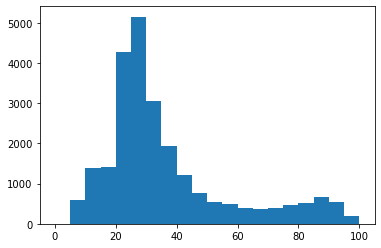

In [6]:
#path = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root'
path = './data/opendata_muons_skimmed.root'
file = ROOT.TFile.Open(path)
tree = file.Events
tree.Print()
# Can iterate over t
dimuon_pt = []
for i,event in enumerate(tree):
    #if i % 1000 == 0:
    #    print('Processing event {}'.format(i))
    if event.nMuon == 2:
        dimuon_pt.append(event.Muon_pt[0] + event.Muon_pt[1])
    if i == 100000:
        break
plt.hist(dimuon_pt, range=(0, 100), bins=20);

### RDataFrame

The modern interface to process datasets in ROOT files (aka TTrees) is RDataFrame. The concept is a computation graph, which is built in a declarative manner, and executes the booked computations as efficient as possible.

In [7]:
df = ROOT.RDataFrame('Events', path)

We filter the dataset for events with two muons and opposite charge. The last line restricts the full dataset to a subset of the in total 66 mio. events.

In [8]:
df = df.Filter("nMuon == 2", "Events with exactly two muons")\
       .Filter("Muon_charge[0] != Muon_charge[1]", "Muons with opposite charge")\
       .Range(20000)

In [9]:
ROOT.gInterpreter.Declare(
"""
using Vec_t = const ROOT::VecOps::RVec<float>&;
float compute_mass(Vec_t pt, Vec_t eta, Vec_t phi, Vec_t mass) {
    ROOT::Math::PtEtaPhiMVector p1(pt[0], eta[0], phi[0], mass[0]);
    ROOT::Math::PtEtaPhiMVector p2(pt[1], eta[1], phi[1], mass[1]);
    return (p1 + p2).mass();
}
""")
df = df.Define("Dimuon_mass", "compute_mass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

In [10]:
hist = df.Histo1D(("hist", ";m_{#mu#mu} (GeV);N_{Events}", 5000, 2, 200), "Dimuon_mass")

In [11]:
report = df.Report()

In [12]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
c.SetLogx(); c.SetLogy()
hist.Draw()

label = ROOT.TLatex(); label.SetNDC(True)
label.SetTextSize(0.040); label.DrawLatex(0.100, 0.920, "#bf{CMS Open Data}")
label.SetTextSize(0.030); label.DrawLatex(0.630, 0.920, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}");

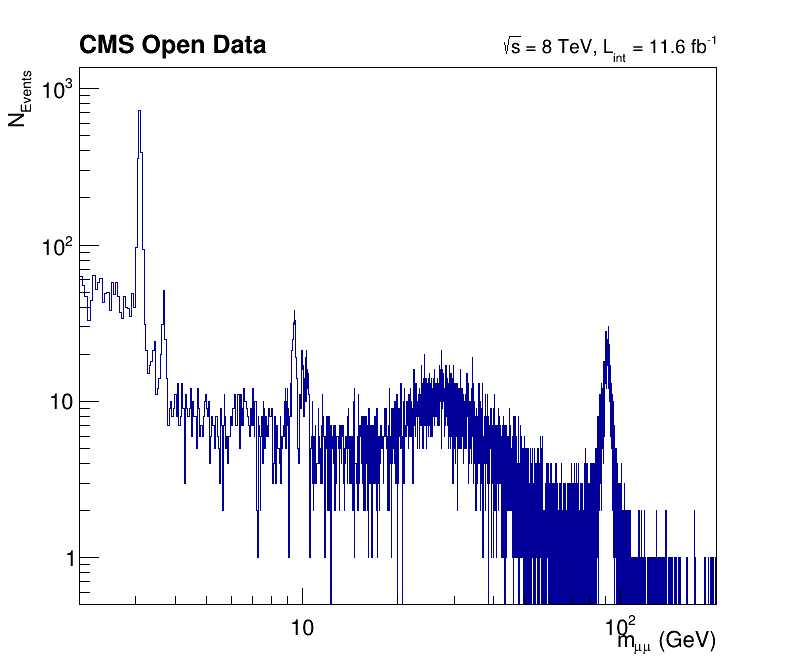

In [13]:
c.Draw()

In [14]:
report.Print()

Events with exactly two muons: pass=24834      all=50000      -- eff=49.67 % cumulative eff=49.67 %
Muons with opposite charge: pass=18827      all=24834      -- eff=75.81 % cumulative eff=37.65 %


RDataFrame can be easily turned into numpy ndarrays or pandas dataframes:

In [16]:
#path = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root'
path = './data/opendata_muons_skimmed.root'
df = ROOT.RDataFrame('Events', path)

npy = df.Filter('nMuon == 2')\
        .Filter('Muon_pt[0] != Muon_pt[1]')\
        .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
        .Range(10000)\
        .AsNumpy(['Dimuon_mass'])

In [17]:
pdf = pd.DataFrame(npy)
print(pdf)

      Dimuon_mass
0       34.415466
1       27.915493
2      113.646866
3        1.587861
4       23.723238
...           ...
9995    24.469269
9996    91.798920
9997    18.113958
9998     1.600781
9999     3.073879

[10000 rows x 1 columns]


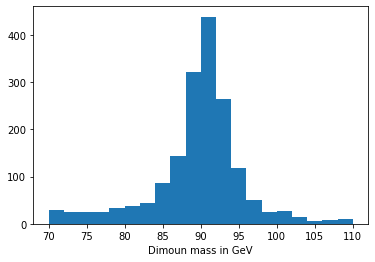

In [18]:
plt.hist(npy['Dimuon_mass'], range=(70, 110), bins=20)
plt.xlabel('Dimoun mass in GeV');

### uproot + awkward array

### Awkward array

In analysis we often have to work with data that can't be represented as a simple table (as if some branches of the tree are arrays of various size).

__[Awkward Arrays](https://github.com/scikit-hep/awkward-1.0)__ provides support for such general tree-like data structures, that are also contiguous in memory and operated upon with compiled, vectorized code like NumPy.

In [19]:
import awkward1 as ak

In [20]:
array = ak.Array([
    [{"mu_m": 90, "jets_m": [1]}, 
     {"mu_m": 50, "jets_m": [1, 2]}, 
     {"mu_m": [30,50,70], "jets_m": [1, 2, 3]}],
    
    [],
    
    [{"mu_m": 40, "jets_m": [1, 2, 3, 4]}, 
     {"mu_m": [], "jets_m": [1, 2, 3, 4, 5]}]
])


In [21]:
print(array["mu_m"])
print(array["jets_m"])

[[90, 50, [30, 50, 70]], [], [40, []]]
[[[1], [1, 2], [1, 2, 3]], [], [[1, 2, 3, 4], [1, 2, 3, 4, 5]]]


In [22]:
output = np.square(array["jets_m", ..., 1:])
print(output)

[[[], [4], [4, 9]], [], [[4, 9, 16], [4, 9, 16, 25]]]


### uproot

uproot (originally μproot, for "micro-Python ROOT") is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike the standard C++ ROOT implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in Python. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT. Instead, it uses Numpy to cast blocks of data from the ROOT file as Numpy arrays.

Uproot is a Python package; it is pip and conda-installable, and it only depends on other Python packages. Although it is similar in function to root_numpy and root_pandas, it does not compile into ROOT and therefore avoids issues in which the version used in compilation differs from the version encountered at runtime.

In [23]:
import uproot4 as uproot

file = uproot.open("http://scikit-hep.org/uproot3/examples/nesteddirs.root")
file

<ReadOnlyDirectory '/' at 0x7f70afec8520>

uproot.open returns a ROOTDirectory, which behaves like a Python dict; it has keys(), values(), and key-value access with square brackets.

In [24]:
file.keys()

['one;1',
 'one/two;1',
 'one/two/tree;1',
 'one/tree;1',
 'three;1',
 'three/tree;1']

In [25]:
file['one']

<ReadOnlyDirectory '/one' at 0x7f70afec8e50>

In [26]:
file['one'].values()

[<ReadOnlyDirectory '/one/two' at 0x7f70afec8550>,
 <TTree 'tree' (20 branches) at 0x7f70afec8580>,
 <TTree 'tree' (3 branches) at 0x7f70afee5640>]

TTrees are special objects in ROOT files: they contain most of the physics data. Uproot presents TTrees as subclasses of TTreeMethods.

In [28]:
path = './data/opendata_muons_skimmed.root'

file = uproot.open(path)
file

<ReadOnlyDirectory '/' at 0x7f70e6710f10>

In [29]:
file.keys()

['Events;1']

In [30]:
file.classnames()

{'Events': 'TTree'}

In [31]:
tree = file["Events"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


In [32]:
tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [33]:
tree.items()

[('nMuon', <TBranch 'nMuon' at 0x7f70e66df7f0>),
 ('Muon_pt', <TBranch 'Muon_pt' at 0x7f70e66dffd0>),
 ('Muon_eta', <TBranch 'Muon_eta' at 0x7f70e66e47c0>),
 ('Muon_phi', <TBranch 'Muon_phi' at 0x7f70e66e4e80>),
 ('Muon_mass', <TBranch 'Muon_mass' at 0x7f70e66e8670>),
 ('Muon_charge', <TBranch 'Muon_charge' at 0x7f70e66e8bb0>)]

In [34]:
tree.typenames()

{'nMuon': 'uint32_t',
 'Muon_pt': 'float[]',
 'Muon_eta': 'float[]',
 'Muon_phi': 'float[]',
 'Muon_mass': 'float[]',
 'Muon_charge': 'int32_t[]'}

In [35]:
tree.keys(filter_name="Muon_*")

['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [36]:
tree.keys(filter_typename="float[]")

['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass']

In [37]:
tree.keys(filter_branch=lambda branch: not isinstance(branch.interpretation, uproot.AsJagged))

['nMuon']

In [38]:
tree["Muon_pt"].array()

<Array [[10.8, 15.7], [10.5, ... [4.81, 18]] type='50000 * var * float32'>

In [39]:
tree["Muon_pt"].array()[:20].tolist()

[[10.763696670532227, 15.736522674560547],
 [10.538490295410156, 16.327096939086914],
 [3.2753264904022217],
 [11.429154396057129, 17.634033203125, 9.624728202819824, 3.502225160598755],
 [3.2834417819976807, 3.64400577545166, 32.911224365234375, 23.72175407409668],
 [3.566528081893921, 4.572504043579102, 4.371862888336182],
 [57.6067008972168, 53.04507827758789],
 [11.31967544555664, 23.906352996826172],
 [10.19356918334961, 14.204060554504395],
 [11.470704078674316, 3.4690065383911133],
 [8.82088565826416, 17.640625],
 [14.5940580368042, 12.346529960632324],
 [35.57528305053711,
  15.075876235961914,
  20.153141021728516,
  27.559505462646484,
  7.394664287567139,
  6.029187202453613],
 [21.814958572387695, 9.548975944519043, 9.808515548706055],
 [4.340000629425049, 13.142794609069824],
 [3.8378028869628906],
 [15.200817108154297, 10.510826110839844],
 [38.77178955078125, 14.144120216369629],
 [13.187382698059082, 8.904003143310547],
 [5.302141189575195, 15.658161163330078]]

In [40]:
tree["Muon_pt"].array(library="np")[:20]

array([array([10.763697, 15.736523], dtype=float32),
       array([10.53849 , 16.327097], dtype=float32),
       array([3.2753265], dtype=float32),
       array([11.429154 , 17.634033 ,  9.624728 ,  3.5022252], dtype=float32),
       array([ 3.2834418,  3.6440058, 32.911224 , 23.721754 ], dtype=float32),
       array([3.566528, 4.572504, 4.371863], dtype=float32),
       array([57.6067 , 53.04508], dtype=float32),
       array([11.319675, 23.906353], dtype=float32),
       array([10.193569, 14.204061], dtype=float32),
       array([11.470704 ,  3.4690065], dtype=float32),
       array([ 8.820886, 17.640625], dtype=float32),
       array([14.594058, 12.34653 ], dtype=float32),
       array([35.575283 , 15.075876 , 20.153141 , 27.559505 ,  7.3946643,
        6.029187 ], dtype=float32),
       array([21.814959,  9.548976,  9.808516], dtype=float32),
       array([ 4.3400006, 13.142795 ], dtype=float32),
       array([3.837803], dtype=float32),
       array([15.200817, 10.510826], dtype=fl

In [41]:
awkward_array = tree["Muon_pt"].array(library="ak")
numpy_array = tree["Muon_pt"].array(library="np")

In [42]:
awkward_array[:20, 0]

<Array [10.8, 10.5, 3.28, ... 38.8, 13.2, 5.3] type='20 * float32'>

In [43]:
numpy_array[:20]

array([array([10.763697, 15.736523], dtype=float32),
       array([10.53849 , 16.327097], dtype=float32),
       array([3.2753265], dtype=float32),
       array([11.429154 , 17.634033 ,  9.624728 ,  3.5022252], dtype=float32),
       array([ 3.2834418,  3.6440058, 32.911224 , 23.721754 ], dtype=float32),
       array([3.566528, 4.572504, 4.371863], dtype=float32),
       array([57.6067 , 53.04508], dtype=float32),
       array([11.319675, 23.906353], dtype=float32),
       array([10.193569, 14.204061], dtype=float32),
       array([11.470704 ,  3.4690065], dtype=float32),
       array([ 8.820886, 17.640625], dtype=float32),
       array([14.594058, 12.34653 ], dtype=float32),
       array([35.575283 , 15.075876 , 20.153141 , 27.559505 ,  7.3946643,
        6.029187 ], dtype=float32),
       array([21.814959,  9.548976,  9.808516], dtype=float32),
       array([ 4.3400006, 13.142795 ], dtype=float32),
       array([3.837803], dtype=float32),
       array([15.200817, 10.510826], dtype=fl

In [44]:
tree["Muon_pt"].array(library="pd")

entry  subentry
0      0           10.763697
       1           15.736523
1      0           10.538490
       1           16.327097
2      0            3.275326
                     ...    
49997  1           17.039013
       2            7.332198
49998  0            3.160125
49999  0            4.814294
       1           18.021034
Length: 117272, dtype: float32

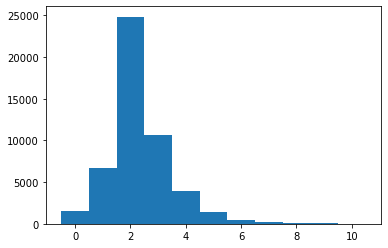

In [46]:
plt.hist(uproot.open("./data/opendata_muons_skimmed.root:Events/nMuon"), bins=11, range=(-0.5, 10.5));

In [47]:
# NumPy arrays in a dict
pv_numpy = tree.arrays(filter_name="Muon_*", library="np")
pv_numpy

{'Muon_pt': array([array([10.763697, 15.736523], dtype=float32),
        array([10.53849 , 16.327097], dtype=float32),
        array([3.2753265], dtype=float32), ...,
        array([47.185143, 17.039013,  7.332198], dtype=float32),
        array([3.1601255], dtype=float32),
        array([ 4.8142943, 18.021034 ], dtype=float32)], dtype=object),
 'Muon_eta': array([array([ 1.0668273, -0.5637865], dtype=float32),
        array([-0.42778006,  0.34922507], dtype=float32),
        array([2.2108555], dtype=float32), ...,
        array([-0.07527801,  1.9864665 ,  2.129292  ], dtype=float32),
        array([-2.0919852], dtype=float32),
        array([-1.6316211, -0.5164791], dtype=float32)], dtype=object),
 'Muon_phi': array([array([-0.03427272,  2.5426154 ], dtype=float32),
        array([-0.2747921,  2.5397813], dtype=float32),
        array([-1.2234136], dtype=float32), ...,
        array([-2.9690173 ,  0.24665758,  2.102427  ], dtype=float32),
        array([1.5526576], dtype=float32),
   

In [48]:
# Awkward record-array
pv_awkward = tree.arrays(filter_name="Muon_*", library="ak")
pv_awkward

<Array [{Muon_pt: [10.8, 15.7], ... 1, 1]}] type='50000 * {"Muon_pt": var * floa...'>

In [49]:
# Pandas DataFrame (as opposed to Series for a single array)
pv_pandas = tree.arrays(filter_name="Muon_*", library="pd")
pv_pandas

Muon_pt  Muon_eta  Muon_phi  Muon_mass  Muon_charge
entry subentry                                                       
0     0         10.763697  1.066827 -0.034273   0.105658           -1
      1         15.736523 -0.563787  2.542615   0.105658           -1
1     0         10.538490 -0.427780 -0.274792   0.105658            1
      1         16.327097  0.349225  2.539781   0.105658           -1
2     0          3.275326  2.210855 -1.223414   0.105658            1
...                   ...       ...       ...        ...          ...
49997 1         17.039013  1.986467  0.246658   0.105658           -1
      2          7.332198  2.129292  2.102427   0.105658            1
49998 0          3.160125 -2.091985  1.552658   0.105658            1
49999 0          4.814294 -1.631621  0.655841   0.105658            1
      1         18.021034 -0.516479 -2.331005   0.105658            1

[117272 rows x 5 columns]

Uproot also has a limited ability to write ROOT files, including TTrees of flat data (non-jagged: single number per event), a variety of histogram types, and TObjString (for metadata).

### hist

Hist is a analyst friendly front-end for boost-histogram, designed for Python 3.6+.

In [50]:
from hist import Hist

# Quick construction, no other imports needed:
h = (
  Hist.new
  .Reg(10, 0 ,10, name="x", label="x-axis")
  .Var(range(10), name="y", label="y-axis")
  .Int64()
)
# Filling by names is allowed:
h.fill(y=[1, 4, 6, 9, 2, 2, 3 ], x=[3, 5, 2, 5, 3, 3, 5])

Hist(
  Regular(10, 0, 10, name='x', label='x-axis'),
  Variable([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  storage=Int64()) # Sum: 6.0 (7.0 with flow)

In [51]:
# Names can be used to manipulate the histogram:
h.project("x")

Hist(Regular(10, 0, 10, name='x', label='x-axis'), storage=Int64()) # Sum: 7.0

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f70dee24430>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f70dee3e4f0>)

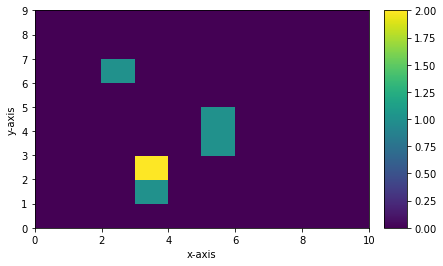

In [52]:
# Elegant plotting functions:
h.plot()


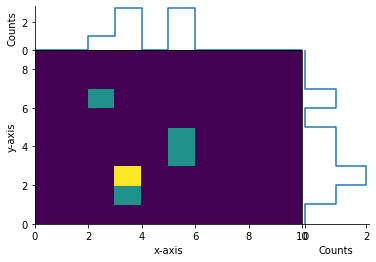

In [53]:
h.plot2d_full();

## Fitting

### iminuit

iminuit is a Jupyter-friendly Python frontend to the MINUIT2 C++ library (which is also used for fitting in ROOT).

It can be used as a general robust function minimisation method, but is most commonly used for likelihood fits of models to data, and to get model parameter error estimates from likelihood profile analysis.

In the next example it is show how it can be used to perform simple least squares fit

In [82]:
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit.util import describe, make_func_code
# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
import matplotlib.pyplot as plt 
import math


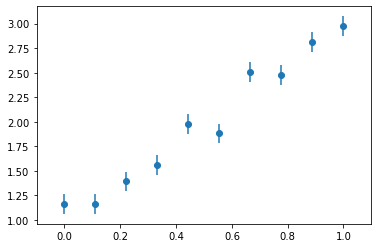

In [55]:
# our line model
def line(x, a, b):
    return a + x * b

# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1 # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlim(-0.1, 1.1);

a = 1.007 +/- 0.059
b = 1.966 +/- 0.099


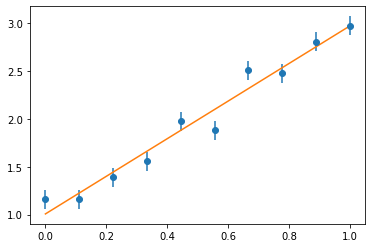

In [57]:
# a simple least-squares cost function looks like this...
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr ** 2
    return np.sum(z ** 2)

# ...but instead of writing this by hand, it is better and
# more convenient to use the LeastSquares class shipped with iminuit
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, a=0, b=0)  # we need starting values for a and b

m.migrad() # finds minimum of least_squares function
m.hesse()  # computes errors 

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.plot(data_x, line(data_x, *m.values.values()))

# print parameter values and uncertainty estimates
for p in m.parameters:
    print("{} = {:.3f} +/- {:.3f}".format(p, m.values[p], m.errors[p]))

In [59]:
data = np.load('./data/pol_data_09_Dec_2020_14:10:54.npy')

In [60]:
print(data[:10])

[[0.00000000e+00 1.59272944e+03 2.05176819e+02]
 [3.14159265e-02 1.55694023e+03 2.02204920e+02]
 [6.28318531e-02 1.51662124e+03 1.95460467e+02]
 [9.42477796e-02 1.47190746e+03 1.88492120e+02]
 [1.25663706e-01 1.44369722e+03 1.83382401e+02]
 [1.57079633e-01 1.39524546e+03 1.78211838e+02]
 [1.88495559e-01 1.34531066e+03 1.74356722e+02]
 [2.19911486e-01 1.30239889e+03 1.66941839e+02]
 [2.51327412e-01 1.27566954e+03 1.61481464e+02]
 [2.82743339e-01 1.23341844e+03 1.56384323e+02]]


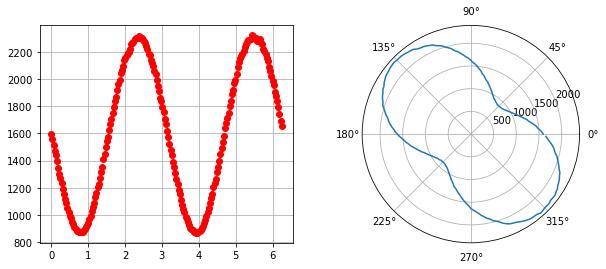

In [65]:
def plot_pol_data(data, mod=None):
    
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.grid()
    ax2 = fig.add_subplot(122, polar=True)

    ax1.plot(data[:,0],data[:,1],'ro')
   
    ax2.plot(data[:,0],data[:,1])
    if mod is not None:
        x_model = np.linspace(0,2*math.pi,num=200)
        y_model = fit_func(x_model,mod['a'], mod['omega'], mod['phi'],mod['offset'])
        ax1.plot(x_model,y_model,'b')
    plt.show() 
plot_pol_data(data)

In [66]:
class MyChi2:
    def __init__(self, model, x, y):
        self.model = model  # model predicts y for given x
        self.x = np.array(x)
        self.y = np.array(y)
        self.y_err = np.where(self.y > 0, np.sqrt(self.y),1)
        self.func_code = make_func_code(describe(self.model)[1:])

    def __call__(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.x, *par)
        self.y = np.where(self.y_err > 0, self.y,0)
        chi2 = np.sum(np.where(self.y > 0, (self.y-ym)**2/self.y_err**2,0))
        return chi2


In [67]:
def fit_func(x, a, omega, phi, offset):
    return offset + a*np.power(np.cos(omega*x + phi),2)

In [68]:
chi2 = MyChi2(fit_func, data[:,0], data[:,1])
m = Minuit(chi2, 
    limit_a=(100,4500),
    error_a=1.,
    limit_omega=(0,2),
    error_omega=0.001,
    limit_phi=(-1.6,1.6),
    error_phi=0.001,
    limit_offset=(0,3000),
    error_offset=1,
    pedantic=True,
    errordef=1)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.91                      │        Nfcn = 441 (441 total)        │
│ EDM = 1.02e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a      │  1.441e3  │  0.008e3  │            │            │   100   │  4500   │       │
│ 1 │ omega  │  1.0009   │  0.0015   │            │            │    0    │    2    │       │
│ 2 │ phi    │   0.786   │   0.005   │            │            │  -1.6   │   1.6   │       │
│ 3 │ offset │    884    │     4     │            │            │    0    │  3000   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

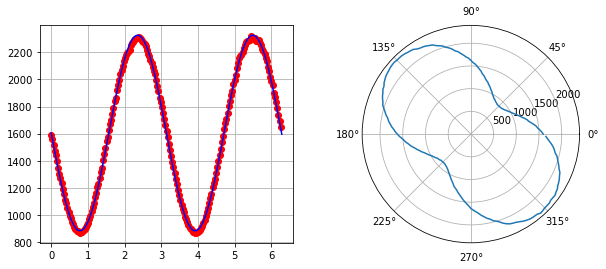

In [69]:
plot_pol_data(data, m.values)

### zfit

The basic idea behind zfit is to offer a Python oriented alternative to the very successful RooFit library from the ROOT data analysis package that can integrate with the other packages that are part if the scientific Python ecosystem. Contrary to the monolithic approach of ROOT/RooFit, the aim of zfit is to be light and flexible enough to integrate with any state-of-art tools and to allow scalability going to larger datasets.

In [70]:
import tensorflow as tf

import zfit
# Wrapper for some tensorflow functionality
from zfit import z
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.2.0


In [71]:
obs = zfit.Space('x', limits=(-10, 10))

In [72]:
mu_true = 0
sigma_true = 1

data_np = np.random.normal(mu_true, sigma_true, size=10000)
data = zfit.data.Data.from_numpy(obs=obs, array=data_np)

In [73]:
mu = zfit.Parameter("mu", 2.4, -1., 5., step_size=0.001)  # step_size is not mandatory but can be helpful
sigma = zfit.Parameter("sigma", 1.3, 0, 5., step_size=0.001)  # it should be around the estimated uncertainty

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-12-13 21:01:22.076143: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-12-13 21:01:22.098351: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2020-12-13 21:01:22.098823: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a7c6900520 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-13 21:01:22.098845: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-13 21:01:22.098947: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [74]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

In [75]:
# Create the negative log likelihood

nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)  # loss

# Load and instantiate a minimizer
minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

# Get the fitted values, again by run the variable graphs
params = minimum.params

print("mu={}".format(params[mu]['value']))
print("sigma={}".format(params[sigma]['value']))

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


/home/stepan/miniconda3/envs/ml-lpi/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:124: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.417e+04                  │         Nfcn = 62 (62 total)         │
│ EDM = 1.05e-09 (Goal: 0.0001)    │        Ngrad = 11 (11 total)         │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
mu=0.009809048186498748
sigma=0.9981660670136377
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =    31663.1667688 Edm =      360.993 NCalls =      1
VariableMetric: Iteration #   0 - FCN =    31

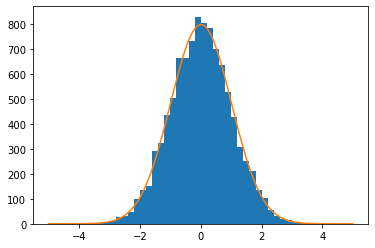

In [76]:
n_bins = 50
range_ = (-5,5)
_ = plt.hist(data_np, bins=n_bins, range=range_)
x = np.linspace(*range_, num=1000)
with gauss.set_norm_range(range_):
    pdf = zfit.run(gauss.pdf(x))
_ = plt.plot(x, data_np.shape[0] / n_bins * (range_[1] - range_[0]) * pdf)

### pyhf

The HistFactory p.d.f. template [__[CERN-OPEN-2012-016](https://cds.cern.ch/record/1456844)__] is per-se independent of its implementation in ROOT and sometimes, it’s useful to be able to run statistical analysis outside of ROOT, RooFit, RooStats framework.

pyhf is a pure-python implementation of that statistical model for multi-bin histogram-based analysis and its interval estimation is based on the asymptotic formulas of “Asymptotic formulae for likelihood-based tests of new physics” [__[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)__]. The aim is also to support modern computational graph libraries such as PyTorch and TensorFlow in order to make use of features such as autodifferentiation and GPU acceleration.

/home/stepan/miniconda3/envs/ml-lpi/lib/python3.8/site-packages/pyhf/infer/calculators.py:229: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


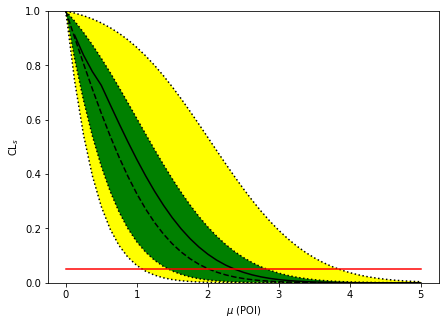

In [77]:
import pyhf
import pyhf.contrib.viz.brazil

pyhf.set_backend("numpy")
model = pyhf.simplemodels.hepdata_like(
    signal_data=[10.0], bkg_data=[50.0], bkg_uncerts=[7.0]
)
data = [55.0] + model.config.auxdata

poi_vals = np.linspace(0, 5, 41)
results = [
    pyhf.infer.hypotest(test_poi, data, model, qtilde=True, return_expected_set=True)
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.set_xlabel(r"$\mu$ (POI)")
ax.set_ylabel(r"$\mathrm{CL}_{s}$")
pyhf.contrib.viz.brazil.plot_results(ax, poi_vals, results)

### hepstats

The hepstats module includes modeling, hypotests and splot submodules.

The modeling submodule includes the Bayesian Block algorithm that can be used to improve the binning of histograms. The visual improvement can be dramatic, and more importantly, this algorithm produces histograms that accurately represent the underlying distribution while being robust to statistical fluctuations. Here is a small example of the algorithm applied on Laplacian sampled data, compared to a histogram of this sample with a fine binning.

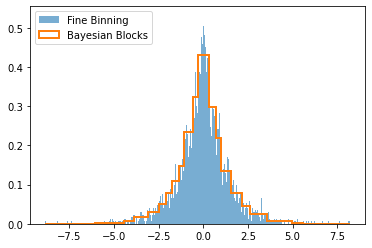

In [79]:
from hepstats.modeling import bayesian_blocks

data = np.random.laplace(size=10000)
blocks = bayesian_blocks(data)

plt.hist(data, bins=1000, label='Fine Binning', density=True, alpha=0.6)
plt.hist(data, bins=blocks, label='Bayesian Blocks', histtype='step', density=True, linewidth=2)
plt.legend(loc=2)

### hepunits

hepunits collects the most commonly used units and constants in the HEP System of Units, as derived from the basic units originally defined by the CLHEP project. The package is in agreement with the values in the 2020 Particle Data Group review.

In [80]:
from hepunits.constants import c_light
from hepunits.units     import picosecond, micrometer
tau_Bs = 1.5 * picosecond    # a particle lifetime, say the Bs meson's
ctau_Bs = c_light * tau_Bs   # ctau of the particle, ~450 microns
print(ctau_Bs)                # result in HEP units, so mm
print(ctau_Bs / micrometer)

0.44968868700000003
449.688687


In [81]:
# add two quantities with length units and get the result in meters
from hepunits import units as u
print((1 * u.meter + 5 * u.cm) / u.meter)
# the default result is, of course, in HEP units, so mm
print(1 * u.meter + 5 * u.cm)

1.05
1050.0
